<img src="media/Cryo+ESA_Logo_plain-50gray.svg" alt="CCI Cryosphere banner" width="1000"/>

# Visualing sea ice concentrations
In this exercise you will use the cate python toolbox to visualize sea ice. After doing this exercise you'll have a good idea to see how sea ice changes over the season, and you'll understand how it changes over the years. 

<img src="media/Thin_sea-ice.jpg" alt="A picture of sea ice taken from a boat" width="1000"/>

*Floating chunks of sea ice, [source](https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2016/12/thin_sea-ice/16576336-1-eng-GB/Thin_sea-ice.jpg)*

## Preparations
If you haven't done so please follow the [Cate tutorial](futurelearn.com/tbd) to get started using the exercises.


## Cate software and the open data portal

In this exercise we'll be querying the open data portal for sea ice concentration products as produced by the [Climate Change Initiative Sea Ice project](https://climate.esa.int/en/projects/sea-ice/). The [**open data portal**](https://climate.esa.int/en/odp/#/dashboard) hosts a variety of datasets on the [Jasmin infrastructure on the UK](https://jasmin.ac.uk/). These can be queried using the dedicated [Cate python module](https://cate.readthedocs.io/en/latest/). Cate allows retrieving data from the data portal and the web-interface which you find at [cate.climate.esa.int](https://cate.climate.esa.int) is build upon it.

In this Jupyter notebook exercise we will directly call Cate functions, and it will show you how these can be used in advanced worksflows.


## Step 1: loading python modules and initialize the data store pool

In [1]:
# To get things started we need to initialize a few things
#Load some python modules to make them accessible to the notebook
from cate.core.ds import DATA_STORE_POOL
import cate.ops as ops
from cate.ops.io import open_dataset

# the following is needed to run Cate in a Jupyter Notebook
from xcube.util.ipython import enable_asyncio
enable_asyncio()

# utilities
from IPython.display import display
import numpy as np
from datetime import datetime


To begin, let us see which data stores are available in the Data Store Pool.

In [2]:
DATA_STORE_POOL.store_instance_ids

['cci-store', 'cci-zarr-store', 'local']

We see three stores. The 'cci-store' is a store that provides access to all datasets from the CCI Open Data Portal. The 'cci-zarr-store' is a store that contains selected data from the Open Data Portal, converted to the zarr format. The datasets from this store can be opened and processed faster, but the store provides only a small subset of what is offered by the 'cci-store'. The 'local' data store finally allows to access locally provided data. Also, when you select to cache data, you will find it in this store. Cached data can also be opened quickly.

For starters, let us use the 'cci-store' which connects to the Open Data Portal and allows access to the datasets listed at https://catalogue.ceda.ac.uk. We can ask for the search parameters of the store to see how a search can be performed.

In [3]:
data_store = DATA_STORE_POOL.get_store('cci-store')
data_store.get_search_params_schema()

## Step 2: Finding sea ice concentration data
For this exercise, we are interested in Sea Ice datasets, so we ask for datasets of the essential Climate Variable (ecv) "SEAICE". Also, to further restrict our search, we look for the data type 'SICONC', as we are interested in Sea Ice Concentration. We then display the results of the query.

In [ ]:
# To get an idea of what is available in the online data portal one can query it and loop over it's result to print some information to the screen
#the query siconc is short for sea ice concentration
seaiceqry=data_store.search_data(ecv='SEAICE', data_type="SICONC")

for i,seaiceItem in enumerate(seaiceqry):
    print("\nDataset item %d:\nds_id: %s"%(i,seaiceItem.data_id))
    display(seaiceItem)

Of these, we pick "esacci.SEAICE.day.L4.SICONC.multi-sensor.multi-platform.AMSR_50kmEASE2.2-1.NH", the 50 km resolution sea ice concentration dataset which has daily values, and open it. Here, we also want to only look at the data from the year 2012, so we build a time range and pass it as parameter. The parameter 'data_store_id' is not absolutely necessary, but it makes the opening a little faster. The parameter 'normalize' should be used so that the dataset is preprocessed in a way that it can be optimally used in Cate.

In [3]:
yr=2012
trange=[datetime(yr,1,1),datetime(yr,12,31)]

seaiceDset=open_dataset(ds_id="esacci.SEAICE.day.L4.SICONC.multi-sensor.multi-platform.AMSR_50kmEASE2.2-1.NH",
                        data_store_id='cci-store',
                        time_range=trange)

/home/jovyan/.local/lib/python3.8/site-packages/xcube_cci/chunkstore.py:181: UserWarning: Could not find dimensions of variable 'Lambert_Azimuthal_Grid'. Will omit it from the dataset.
  warnings.warn(f"Could not find dimensions of variable '{variable_name}'. "


## Step 3: Visualize the arctic sea ice concentration on a given day
Once the data is loaded we can use the plotting function of [xarray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html) for a quick visualization. You can also try to plot a different day. by changing the `ithday` parameter

plotting sea ice at 2012-07-23


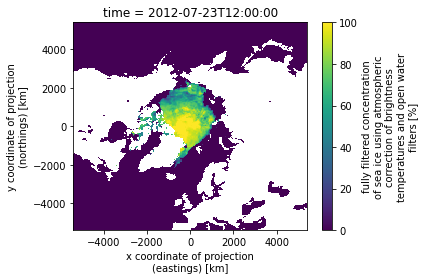

In [11]:
# Plot the sea ice concentration on a chosen day
%matplotlib inline
import numpy as np
ithday=204
print("plotting sea ice at %s"%np.datetime_as_string(seaiceDset.time[ithday], unit='D'))
seaiceDset.ice_conc.isel(time=ithday).plot()

## Step 4: Create an animation of the Arctic sea ice concentration
To find out how the sea ice concentration behaves over time, we will make an animation using matplotlib

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation,cm
from IPython.display import HTML
import numpy as np
from copy import copy
# Make sure that the initial iconcentrationmage is not shown inline in the notebook
%matplotlib

# We also want to visualize the chang over time so we create an animation with the python module matplotlib
# You can find more information on matplotlib animations here: https://matplotlib.org/stable/api/animation_api.html

ith=0
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

cmSea=copy(cm.get_cmap("bone"))
cmSea.set_bad('grey') #this will plot land nodes as gray
im=ax.imshow(seaiceDset.ice_conc.isel(time=ith).data,cmap=cmSea, vmin=0, vmax=100)

istart=204 #only start from this frame (you can change this to make longer animations)
nframes=seaiceDset.dims["time"] - istart

# a initial function
def initSeaice():
    ax.set_title("Sea ice concentration %s"%np.datetime_as_string(seaiceDset.time[ith+istart],unit="D"))    
    return (im,)

#function which will provide the content for the different frames
def animSeaIce(i):
    print(f"Animating frame {i} of {nframes - 1}", end="\r")
    ax.set_title("Sea ice concentration %s"%np.datetime_as_string(seaiceDset.time[i+istart],unit="D"))
    im.set_array(seaiceDset.ice_conc.isel(time=i+istart).data)
    return (im,)

anim = animation.FuncAnimation(fig, animSeaIce, init_func=initSeaice,
                               frames=nframes, interval=100, 
                               blit=True)

# The to_jshtml call creates some html code and javascript which allows us to control the animation
HTML(anim.to_jshtml())

Using matplotlib backend: agg


# Questions (please share your answers and discuss these on the forum)
Now that you've done the exercise, it's time to reflect on what you can learn from the data.

1. Why is there a relative small amount of sea ice between Greenland and Norway?
2. There are certain locations where not all of the sea ice melts in summer, so called multi-year sea ice. In which locations do you expect to find this multi year sea ice?
3. Try to search online for seasons with expectional low and high coverage of sea ice, and repeat the exercise for those years by modifying the python `yr` variable.
4. How does the sea ice grow in the Russian Arctic? From the coast, the existing sea ice in the central Arctic, or both?